In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

# 주성분분석(Principal Component Analysis)을 하기 위한 라이브러리
from sklearn.decomposition import PCA

# 파일 경로 확인용

import os
import glob

# .py 파일 가져오기
# import (폴더이름.)파일이름
import src.facenet as facenet
import src.align.detect_face as detect_face

In [2]:
# jupyter notebook 펭지에 그리기
%matplotlib inline

In [3]:
# 학습되어 있는 모델을로드하는 함수
# 입력 : protobuf 파일(모델이 정의되어 있음)
# 리턴 :
#     - single_image : 영상을 입력하는 placeholder (session, run feed_dict 에 사용)
#     - embeddings : 네트어크의 출력 값, 512차원의 추출된 얼굴 특징 벡터

def load_model(pb_path, image_size=(160,160)) :
    tf.reset_default_graph()
    
    single_image = tf.placeholder(tf.int32, (None, None, 3))
    float_image = tf.cast(single_image, tf.float32)
    float_image = float_image/255
    batch_image = tf.expand_dims(float_image, 0)
    resized_image = tf.image.resize(batch_image, image_size)
    
    phase_train = tf.placeholder_with_default(False, shape=[])
    
    input_map = {'image_batch' : resized_image, 'phase_train' : phase_train}
    model = facenet.load_model(pb_path, input_map)
    
    embeddings = tf.get_default_graph().get_tensor_by_name("embeddings: 0")
    
    return single_image, embeddings

In [4]:
# 영상 경로를 입력받아 로드하고, return해주는 함수
def load_image(image_path) :
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

In [5]:
# 두 벡터간의 거리를 계산하는 함수

def calc_distance(embedding1, embedding2) :
    # Euclidian distance
    diff = np.subtract(embedding1, embedding2)
    dist = np.sum(np.square(diff), 0)
    
    return dist

In [6]:
#모델 및 세션 선언
single_image, embeddings = load_model("./models/20180402-114759.pb")

sess = tf.Session()

Model filename: ./models/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.


In [7]:
#내 얼굴의 특징백터 (embedding) 추출
path_me = glob.glob("./data/faces/me/*")
embed_me = []

for path in path_me :
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image : img})
    result = result[0]
    embed_me.append(result)

embed_me = np.array(embed_me)
print(embed_me.shape)

(15, 512)


In [8]:
# 첫 번째 얼굴 사진의 특징벡터 확인
print(embed_me[0])

[ 0.02505372 -0.07428453 -0.02991628 -0.01288518  0.03171775 -0.04412626
  0.06683834 -0.02179219 -0.03255328 -0.01801552  0.08204079 -0.04761723
 -0.01861282 -0.04597505 -0.00639299  0.0772294   0.04968267  0.06020802
  0.00131305  0.06295522  0.02144411 -0.04858133 -0.00418211 -0.03168897
 -0.09273911 -0.02089796 -0.0066261   0.02689565  0.02598977  0.05191024
 -0.01495472 -0.048581   -0.02511165  0.02240819 -0.05704749 -0.0876956
 -0.0008455  -0.01495599  0.0357438   0.0013771  -0.04203856  0.02742895
  0.01508131  0.08668207  0.10104956  0.06624456  0.02252857  0.04219296
 -0.00840825  0.0685001  -0.02329267  0.05728699  0.00488593 -0.02073585
 -0.00069179 -0.01605568 -0.02656865  0.02236516 -0.00742386  0.07447499
 -0.00973325 -0.01581293 -0.01178654 -0.01138156 -0.03479418 -0.03059129
 -0.06196352  0.02468733 -0.08175424 -0.03200725 -0.07345495  0.03508679
  0.024873   -0.01791495 -0.00269705 -0.03644952  0.05325198 -0.01649957
 -0.03341089 -0.05907228 -0.10949568  0.03496176 -0.

In [9]:
#다른 사람 얼굴의 특징벡터 (embedding) 추출
path_other1 = glob.glob("./data/faces/other1/*")

embed_other1 = []

for path in path_other1:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict = {single_image : img})
    result = result[0]
    embed_other1.append(result)
    
embed_other1 = np.array(embed_other1)
print(embed_other1.shape)

(5, 512)


In [10]:
#다른 사람 얼굴의 특징벡터 (embedding) 추출
path_other2 = glob.glob("./data/faces/other2/*")

embed_other2 = []

for path in path_other2:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict = {single_image : img})
    result = result[0]
    embed_other2.append(result)
embed_other2 = np.array(embed_other2)
print(embed_other2.shape)

(22, 512)


In [11]:
# 내 얼굴 1과 내 얼굴 2의 거리 확인
print(calc_distance(embed_me[0], embed_me[1]))

# 내 얼굴 1과 다른 사람 얼굴 1의 거리 확인
print(calc_distance(embed_me[0], embed_other1[0]))

0.33489922
2.2018745


In [12]:
# 기준이 되는 얼굴 임베딩 설정
base_embed = embed_me[0]

print("-------------- 내 얼굴과의 거리 -------------")
# 얼굴 0~N까지 확인
for e in embed_me :
    print(calc_distance(base_embed, e))
    
print("\n\n")
print("------------ 다른 사람 얼굴과의 거리 --------------")
# 다른 사람1, 2를 묶어서 확인
embed_others = np.concatenate((embed_other1, embed_other2), axis=0)
for e in embed_others :
    print(calc_distance(base_embed, e))

-------------- 내 얼굴과의 거리 -------------
0.0
0.33489922
0.61070156
0.39590526
0.33455577
0.38925737
0.42905134
0.5308039
0.46130988
0.34581858
0.5654861
1.5417243
0.6073091
0.405529
0.42542243



------------ 다른 사람 얼굴과의 거리 --------------
2.2018745
2.2223144
2.6078436
2.2714632
2.4002979
1.5449371
1.4870415
1.4761282
1.5066423
1.6596911
1.3668706
1.5273141
1.7088046
1.5948522
1.4229984
1.6489259
1.6104972
1.5920773
1.582396
1.4953953
1.4693184
1.4913878
1.6228371
1.3434358
1.502722
1.5113518
1.6403182


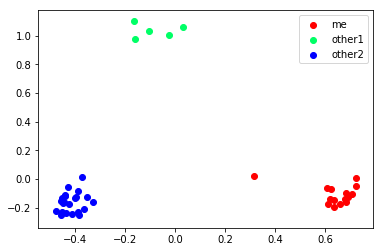

In [13]:
#PCA를 사용한 시각화 (512 -> 2차원으로 감소)
# 모든 임베딩을 묶음
all_embeddings = np.concatenate((embed_me, embed_other1, embed_other2), axis=0)

# PCA 클래스 선언 (n_component는 축소할 차원을 의미
pca = PCA(n_components=2)

# PCA 계산 (이후 pca.transform 함수를 사용하여 512차원을 2차원으로 축소)
pca.fit(all_embeddings)

# PCA를 사용하여 차원 축소
xy_me = pca.transform(embed_me)
xy_other1 = pca.transform(embed_other1)
xy_other2 = pca.transform(embed_other2)

ax = plt.figure()

sc1 = plt.scatter(xy_me[:,0], xy_me[:,1], color=(1, 0, 0))
sc2 = plt.scatter(xy_other1[:,0], xy_other1[:,1], color = (0, 1, 0.4))
sc3 = plt.scatter(xy_other2[:,0], xy_other2[:,1], color = (0, 0, 1))

plt.legend([sc1, sc2, sc3], ["me", "other1", "other2"], loc = "upper right")

In [14]:
#내 얼굴인지 분류
# 영상 경로를 자유롭게 수정
x_path = "./data/faces/me/video_bc2_short0_0.jpg"

image_x = load_image(x_path)
result_x = sess.run(embeddings, feed_dict={single_image : image_x})
result_x = result_x[0]

distance_th = 1.2 # 거리가 얼마 미만이어야 나로 분류할지

distance1 = calc_distance(embed_me[0], result_x)
distance2 = calc_distance(embed_me[3], result_x)

avg_distance = (distance1 + distance2)/2
print("distance:", avg_distance)

if(avg_distance < distance_th):
    print(x_path, "는 내 얼굴입니다.")
else :
    print(x_path, "는 내 얼굴이 아닙니다.")

distance: 0.20147913694381714
./data/faces/me/video_bc2_short0_0.jpg 는 내 얼굴입니다.


In [15]:
# 단일 RGB영상과 pre-trained 네트워크(P/R/O net)를 입력받아
# 1. face detection
# 2. crop(margin추가)
# 3. resize 하고
# 검출된 얼굴 영상들의 리스트를 반환하는 함수

def crop_faces(image, pnet, rnet, onet) :
    # face detection 관련 파라미터
    ####과제할때 이부분 조절하면서 하면됨###################
    minsize = 20 # minimum size of face
    threshold = [0.6, 0.7, 0.7] # thress step's threshold
    factor = 0.709 # scale factor
    ##################################################
    
    # crop 관련 파라미터
    margin = 44 # 상하좌우 여백
    image_size = 160 # resize(scaling) 크기
    
    h,w,_ = np.shape(image)
    
    # 얼굴 검출
    bounding_boxes, points = detect_face.detect_face(image, minsize, pnet, rnet, onet, threshold, factor)
    # bounding_boxes : 검출된 사각형 영역, [x1, y1, x2, y2, 확률]로 이루어진 리스트
    # points : 검출된 얼굴의 주요 landmark [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]로 이루어진 리스트
    
    faces = []
    for box in bounding_boxes :
        box = np.int32(box)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(box[0] - margin/2, 0)
        bb[1] = np.maximum(box[1] - margin/2, 0)
        bb[2] = np.maximum(box[2] - margin/2, w)
        bb[3] = np.maximum(box[3] - margin/2, h)
        cropped = image[bb[1]:bb[3], bb[0]:bb[2], :]
        scaled = cv2.resize(cropped, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
        
        faces.append(scaled)
        
    return faces, bounding_boxes
    

In [16]:
pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


영상에서 검출된 얼굴의 개수: 1


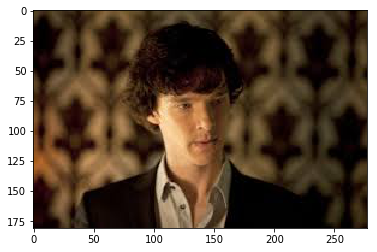

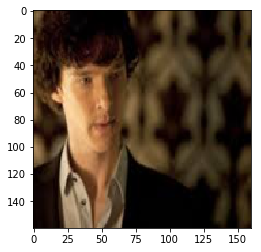

In [17]:
image = load_image("./data/images/me/bc1.jpg")
plt.figure()
plt.imshow(image)

faces, bounding_boxes = crop_faces(image, pnet, rnet, onet)
print("영상에서 검출된 얼굴의 개수:", len(faces))

plt.figure()
plt.imshow(faces[0])

In [18]:
print(bounding_boxes[0])

[100.79861677  53.57836652 165.27135366 132.32560253   0.99986064]


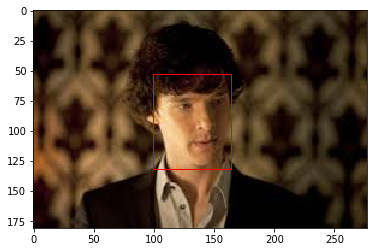

In [19]:
squared_img = image.copy()
for box in bounding_boxes :
    box = np.int32(box)
    p1 = (box[0], box[1])
    p2 = (box[2], box[3])
    cv2.rectangle(squared_img, p1, p2, color = (255, 0, 0))
    
plt.imshow(squared_img)

In [ ]:
#############과제##############
# 사용함수 
# calc_distance (두 벡터간의 거리 계산 함수. 서로 다른 두 얼굴의 특징벡터간 거리.)
# detect_face.creat_mtcnn ()
# load_model

In [6]:
tf.reset_default_graph()
 
single_image, embeddings = load_model("./models/20180402-114759.pb")

sess = tf.Session()
pnet, rnet, onet = detect_face.create_mtcnn(sess,None)

Model filename: ./models/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [7]:
#내 얼굴의 특징백터 (embedding) 추출
path_me = glob.glob("./data/faces/chaelin/*")
embed_me = []

for path in path_me :
    img = load_image(path)
    result = sess.run(embeddings, feed_dict={single_image : img})
    result = result[0]
    embed_me.append(result)

embed_me = np.array(embed_me)
print(embed_me.shape)

# 첫 번째 얼굴 사진의 특징벡터 확인
print(embed_me[0])

(13, 512)
[ 0.05770721 -0.09601963 -0.03570701  0.07592539  0.05971     0.01046605
 -0.01885643 -0.02299473 -0.02491699 -0.00275599  0.08583558  0.04517972
  0.00284191  0.0049621   0.0935327  -0.0518381  -0.04378693 -0.02619195
  0.0320329   0.00998774 -0.02827276  0.03643578  0.04111678 -0.05567232
 -0.04859228  0.02700874 -0.00049343 -0.01870658  0.05326994 -0.05065344
 -0.00420488  0.00624706 -0.00654532 -0.00674152 -0.07032299  0.00247366
 -0.02536036  0.03912397 -0.026828    0.04730934  0.00038517  0.02260369
 -0.00693338 -0.02122674  0.04154959  0.03393304  0.06931549  0.01354835
 -0.0865417  -0.03914642  0.033332   -0.0458115   0.01169788  0.00941827
 -0.04479139 -0.00813048  0.04559938  0.01380016 -0.03600002  0.00436377
 -0.05180239  0.02658583 -0.06762801 -0.02784567  0.03867554  0.03490915
  0.0130773  -0.10342453 -0.08156901 -0.0414778   0.06920744  0.07355628
  0.00716772 -0.02577873 -0.00589166 -0.03991514  0.05100739 -0.00703321
 -0.06131368  0.05101914  0.06783798  0.0

In [11]:
#include <opencv/cv.h>
#include <opencv/highgui.h>
#include <string>

using namespace std;

int main(int argc, char **argv)
{
    IplImage *img;

    CvCapture *capture;
    capture = cvCaptureFromFile(argv[1]);

    int fps;
    int count = 0;

    if(capture){
        while(1)
        {
            img = cvQueryFrame(capture);
            if(!img) break;
            
            cvNamedWindow("image");
            cvShowImage("image",img);
            
            string filename;
            filename = cv::format("capture%03d.bmp", count);
            cvSaveImage(filename.c_str(),img);
            cvWaitKey(1);
            count++;
        }
    }
    cvReleaseCapture(&capture);

    return 0;
}

In [18]:
# vidcap = cv2.VideoCapture('jimin.mp4')
# success,image = vidcap.read()
# count = 0
# while success:
#   cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   count += 1

In [10]:
def video2frame(invideofilename, save_path):
    vidcap = cv2.VideoCapture(invideofilename)
    count = 0
    while True:
      success,image = vidcap.read()
      if not success:
          break
      print ('Read a new frame: ', success)
      fname = "{}.jpg".format("{0:05d}".format(count))
      cv2.imwrite(save_path + fname, image) # save frame as JPEG file
      count += 1
    print("{} images are extracted in {}.". format(count, save_path))


#출처: https://wondy1128.tistory.com/148 [원도블로그]
invideofilename = "jimin.mp4"
save_path = "./"
video2frame(invideofilename, save_path)

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [13]:
invideofilename2 = "sister.mp4"
save_path2 = "./data/faces/others_2/"
video2frame(invideofilename2, save_path2)

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [ ]:
import cv2
cap1 = cv2.VideoCapture("jimin.mp4")
while(cap1.isOpened()):
    ret, frame = cap1.read()
    
    frame = cv2.resize(frame, (400,225))
    
    #detected_faces = FaceDetection(frame)
    
    cv2.imshow("frame", frame)
    #cv2.imshow("detected", detected_faces)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
        
cap1.release()
cv2.detroyAllWindows()

In [14]:
#다른 사람 얼굴의 특징벡터 (embedding) 추출
path_other1 = glob.glob("./data/faces/others_1/*")

embed_other1 = []

for path in path_other1:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict = {single_image : img})
    result = result[0]
    embed_other1.append(result)
    
embed_other1 = np.array(embed_other1)
print(embed_other1.shape)

(105, 512)


In [15]:
#다른 사람 얼굴의 특징벡터 (embedding) 추출
path_other2 = glob.glob("./data/faces/others_2/*")

embed_other2 = []

for path in path_other2:
    img = load_image(path)
    result = sess.run(embeddings, feed_dict = {single_image : img})
    result = result[0]
    embed_other2.append(result)
embed_other2 = np.array(embed_other2)
print(embed_other2.shape)

(136, 512)


In [16]:
# 내 얼굴 1과 내 얼굴 2의 거리 확인
print(calc_distance(embed_me[0], embed_me[1]))

# 내 얼굴 1과 다른 사람 얼굴 1의 거리 확인
print(calc_distance(embed_me[0], embed_other1[0]))

0.46648705
0.68099344


In [17]:
# 기준이 되는 얼굴 임베딩 설정
base_embed = embed_me[0]

print("-------------- 내 얼굴과의 거리 -------------")
# 얼굴 0~N까지 확인
for e in embed_me :
    print(calc_distance(base_embed, e))
    
print("\n\n")
print("------------ 다른 사람 얼굴과의 거리 --------------")
# 다른 사람1, 2를 묶어서 확인
embed_others = np.concatenate((embed_other1, embed_other2), axis=0)
for e in embed_others :
    print(calc_distance(base_embed, e))

-------------- 내 얼굴과의 거리 -------------
0.0
0.46648705
0.29073012
0.77228856
0.30586317
0.5944283
0.50164336
0.53264284
0.43961474
0.43511835
0.54493487
0.20269516
0.1185732



------------ 다른 사람 얼굴과의 거리 --------------
0.68099344
0.84622806
0.9020977
1.2182798
1.2948593
0.9485444
0.86999106
0.6738966
0.78946507
0.7333616
1.1387144
0.97224116
0.8425528
0.95728934
0.9038439
0.8416959
0.70798457
0.80241036
0.89236987
0.8449763
0.68143934
0.9330339
1.1438718
1.0680714
0.90289384
0.6883839
0.746833
0.95678556
0.6863816
0.773165
1.3375516
0.9103486
0.8025675
1.1616921
0.8121399
0.6959249
0.64155555
0.6617664
0.6451001
0.65720916
0.69374925
0.68752843
0.67442155
0.66149724
0.68710876
0.6841384
0.7200477
0.69824004
0.64284015
0.6967437
0.63976216
0.6434368
0.7134478
0.6805864
0.65085703
0.6203915
0.63028175
0.621439
0.69092596
0.6805376
0.632506
0.6214256
0.70440936
0.6541489
0.60454416
0.7101354
0.66920376
0.6474607
0.64391404
0.66036725
0.649883
0.64079106
0.6272298
0.73030806
0.6382878
0.672

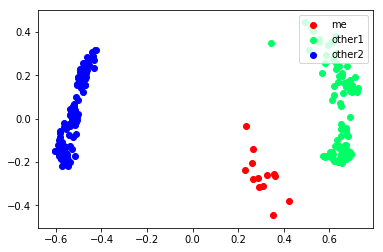

In [18]:
#PCA를 사용한 시각화 (512 -> 2차원으로 감소)
# 모든 임베딩을 묶음
all_embeddings = np.concatenate((embed_me, embed_other1, embed_other2), axis=0)

# PCA 클래스 선언 (n_component는 축소할 차원을 의미
pca = PCA(n_components=2)

# PCA 계산 (이후 pca.transform 함수를 사용하여 512차원을 2차원으로 축소)
pca.fit(all_embeddings)

# PCA를 사용하여 차원 축소
xy_me = pca.transform(embed_me)
xy_other1 = pca.transform(embed_other1)
xy_other2 = pca.transform(embed_other2)

ax = plt.figure()

sc1 = plt.scatter(xy_me[:,0], xy_me[:,1], color=(1, 0, 0))
sc2 = plt.scatter(xy_other1[:,0], xy_other1[:,1], color = (0, 1, 0.4))
sc3 = plt.scatter(xy_other2[:,0], xy_other2[:,1], color = (0, 0, 1))

plt.legend([sc1, sc2, sc3], ["me", "other1", "other2"], loc = "upper right")

In [19]:
#내 얼굴인지 분류
# 영상 경로를 자유롭게 수정
x_path = "./data/faces/me/video_bc2_short0_0.jpg"

image_x = load_image(x_path)
result_x = sess.run(embeddings, feed_dict={single_image : image_x})
result_x = result_x[0]

distance_th = 1.2 # 거리가 얼마 미만이어야 나로 분류할지

distance1 = calc_distance(embed_me[0], result_x)
distance2 = calc_distance(embed_me[3], result_x)

avg_distance = (distance1 + distance2)/2
print("distance:", avg_distance)

if(avg_distance < distance_th):
    print(x_path, "는 내 얼굴입니다.")
else :
    print(x_path, "는 내 얼굴이 아닙니다.")

distance: 1.7270243167877197
./data/faces/me/video_bc2_short0_0.jpg 는 내 얼굴이 아닙니다.


In [20]:
# 단일 RGB영상과 pre-trained 네트워크(P/R/O net)를 입력받아
# 1. face detection
# 2. crop(margin추가)
# 3. resize 하고
# 검출된 얼굴 영상들의 리스트를 반환하는 함수

def crop_faces(image, pnet, rnet, onet) :
    # face detection 관련 파라미터
    ####과제할때 이부분 조절하면서 하면됨###################
    minsize = 20 # minimum size of face
    threshold = [0.6, 0.7, 0.7] # thress step's threshold
    factor = 0.709 # scale factor
    ##################################################
    
    # crop 관련 파라미터
    margin = 44 # 상하좌우 여백
    image_size = 160 # resize(scaling) 크기
    
    h,w,_ = np.shape(image)
    
    # 얼굴 검출
    bounding_boxes, points = detect_face.detect_face(image, minsize, pnet, rnet, onet, threshold, factor)
    # bounding_boxes : 검출된 사각형 영역, [x1, y1, x2, y2, 확률]로 이루어진 리스트
    # points : 검출된 얼굴의 주요 landmark [x1, x2, x3, x4, x5, y1, y2, y3, y4, y5]로 이루어진 리스트
    
    faces = []
    for box in bounding_boxes :
        box = np.int32(box)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(box[0] - margin/2, 0)
        bb[1] = np.maximum(box[1] - margin/2, 0)
        bb[2] = np.maximum(box[2] - margin/2, w)
        bb[3] = np.maximum(box[3] - margin/2, h)
        cropped = image[bb[1]:bb[3], bb[0]:bb[2], :]
        scaled = cv2.resize(cropped, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
        
        faces.append(scaled)
        
    return faces, bounding_boxes

KeyboardInterrupt: 

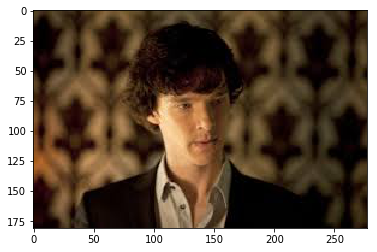

In [25]:
image = load_image("./data/images/me/bc1.jpg")
plt.figure()
plt.imshow(image)

faces, bounding_boxes = crop_faces(image, pnet, rnet, onet)
print("영상에서 검출된 얼굴의 개수:", len(faces))

plt.figure()
plt.imshow(faces[0])

In [23]:
#얼굴인식(사진)
#영상을 입력받아 face detection을 수행하고,
#얼굴 영역에 네모를 그려 return 해주는 함수

def FaceDetection(img):
    color = (255,0,0) # 얼굴 영역을 표시할 네모의 색상 지정
    thickness = 2 # 네모의 두께
    
    result_img = img.copy()
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #이미 학습되어있는 Haar Cascade Classifier 로드
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    
    #얼굴 검출 수행
    faces = face_cascade.detectMultiScale(gray_img, 1.1, 5)
    
    #검출된 얼굴 영역 그리기
    for (x,y,w,h) in faces:
        cv2.rectangle(result_img, (x,y),(x+w, y+h), color, 2)
    return result_img

#얼굴인식(캠)

import numpy as np
import cv2

cap = cv2.VideoCapture(0)

while(cap.isOpened()):
    ret, frame = cap.read()
    
    frame = cv2.resize(frame,(400,225))
    detected_faces = FaceDetection(frame)
    
    cv2.imshow("frame", frame)
    cv2.imshow("detected", detected_faces)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.detroyAllWindows()

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/objdetect/src/cascadedetect.cpp:1698: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'
